# Lya Quasar Weighting

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.table

Read quasar values tabulated on a grid of r-mag and redshift:

In [140]:
def load_weights():

    table = astropy.table.Table.read('quasarvalue.txt', format='ascii')
    z_col, r_col, w_col = table.columns[0], table.columns[1], table.columns[2]

    z_vec = np.unique(z_col)
    z_edges = np.linspace(2.025, 4.025, len(z_vec) + 1)
    assert np.allclose(z_vec, 0.5 * (z_edges[1:] + z_edges[:-1]))

    r_vec = np.unique(r_col)
    r_edges = np.linspace(18.05, 23.05, len(r_vec) + 1)
    assert np.allclose(r_vec, 0.5 * (r_edges[1:] + r_edges[:-1]))
    
    W = np.empty((len(r_vec), len(z_vec)))
    k = 0
    for j in range(len(z_vec)):
        for i in range(len(r_vec))[::-1]:
            assert r_col[k] == r_vec[i]
            assert z_col[k] == z_vec[j]
            W[i, j] = w_col[k]
            k += 1
    return W, r_edges, r_vec, z_edges, z_vec
    
W, r_edges, r_vec, z_edges, z_vec = load_weights()

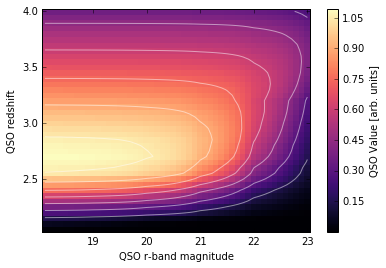

In [117]:
def plot_weights(W=W):
    plt.pcolormesh(r_edges, z_edges, W.T, cmap='magma')
    plt.colorbar().set_label('QSO Value [arb. units]')
    plt.contour(r_vec, z_vec, W.T, colors='w', alpha=0.5)
    plt.xlabel('QSO r-band magnitude')
    plt.ylabel('QSO redshift')

plot_weights()

Rebin weights to the redshift ranges of neural network output categories:

In [110]:
def rebin_weights(new_z_edges=[2.0, 2.5, 3.0, 4.0]):
    n_z = len(new_z_edges) - 1
    W2 = np.empty((len(r_vec), n_z))
    for i in range(len(r_vec)):
        W2[i] = np.histogram(z_vec, bins=new_z_edges, weights=W[i])[0]
    return W2, new_z_edges
    
W2, new_z_edges = rebin_weights()

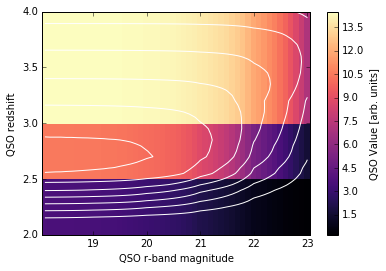

In [120]:
def plot_reweights():
    plt.pcolormesh(r_edges, new_z_edges, W2.T, cmap='magma')
    plt.colorbar().set_label('QSO Value [arb. units]')
    plt.contour(r_vec, z_vec, W.T, colors='w', alpha=1)
    plt.xlabel('QSO r-band magnitude')
    plt.ylabel('QSO redshift')

plot_reweights()

Calculate overall values for a quasar target based on its absolute probabilities of being a quasar in different redshift bins:

In [138]:
def get_values(r_mag, z_prob):
    
    r_mag = np.asarray(r_mag)
    z_prob = np.asarray(z_prob)
    
    assert np.all((r_edges[0] <= r_mag) & (r_mag < r_edges[-1]))
    assert z_prob.shape[-1] == len(new_z_edges) - 1
    assert z_prob.shape[:-1] == r_mag.shape
    assert np.all(z_prob.sum(axis=-1) <= 1.)

    r_index = np.digitize(r_mag, r_edges)
    
    return (W2[r_index] * z_prob).sum(axis=-1)

In [139]:
get_values([19, 19, 19], [[1,0,0],[0,1,0],[0,0,1]])

array([  3.478114,  10.4375  ,  14.4807  ])